In [9]:
# COCO烟雾分割标签可视化
# 本脚本用于可视化COCO格式的烟雾分割标签，原图与标注拼接显示，并用不同颜色区分类别。

import json
import os
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict


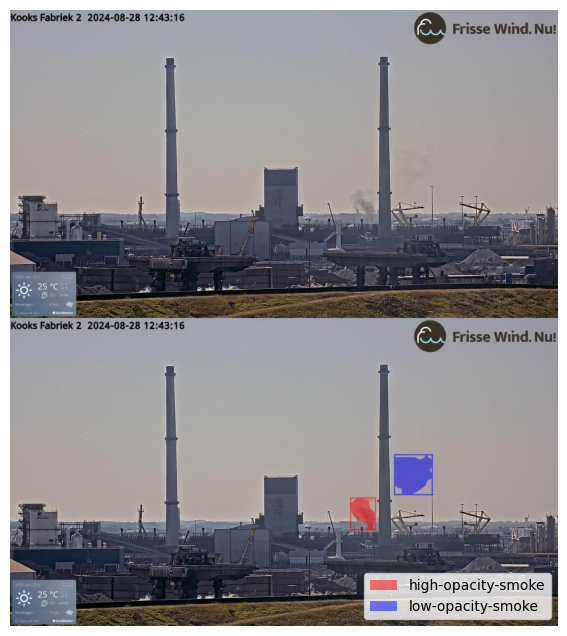

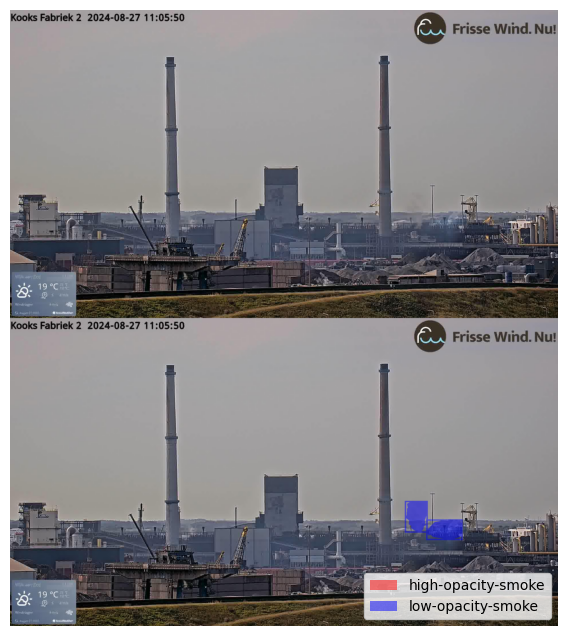

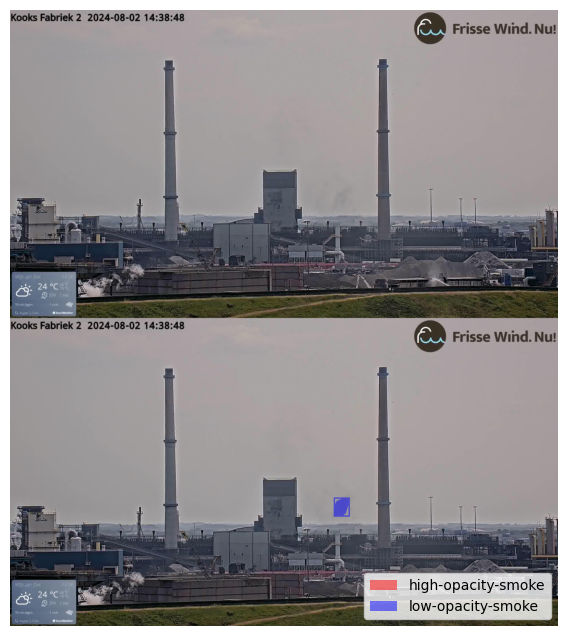

In [10]:

# 路径设置
coco_json = '/home/ytao/Thesis/smoke-segmentation.v5i.coco-segmentation/test/_annotations.coco.json'
img_dir = '/home/ytao/Thesis/smoke-segmentation.v5i.coco-segmentation/test'

# 类别颜色映射
category_colors = {
    1: (255, 0, 0, 128),  # 高透明度烟雾 红色 半透明
    2: (0, 0, 255, 128),  # 低透明度烟雾 蓝色 半透明
}
category_names = {
    1: 'high-opacity-smoke',
    2: 'low-opacity-smoke',
}

# 读取COCO标注
with open(coco_json, 'r') as f:
    coco = json.load(f)

images = {img['id']: img for img in coco['images']}
annotations = coco['annotations']

# 按图片分组标注
img_to_anns = defaultdict(list)
for ann in annotations:
    img_to_anns[ann['image_id']].append(ann)


# 可视化函数
def visualize_one(img_info, anns):
    img_path = os.path.join(img_dir, img_info['file_name'])
    img = Image.open(img_path).convert('RGB')
    mask = Image.new('RGBA', img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)
    for ann in anns:
        cat = ann['category_id']
        if cat == 0:
            continue
        for seg in ann['segmentation']:
            # COCO多边形格式
            xy = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(xy, fill=category_colors[cat])
        # bbox
        x, y, w, h = ann['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        draw.rectangle([x, y, x + w, y + h], outline=category_colors[cat], width=5)
    # 处理透明度
    # 合成
    vis = Image.alpha_composite(img.convert('RGBA'), mask)
    # 拼接
    canvas = Image.new('RGBA', (img.width, img.height * 2))
    canvas.paste(img, (0, 0))
    canvas.paste(vis, (0, img.height))
    return canvas


# 显示一张图片及其标注
def show_with_legend(canvas):
    plt.figure(figsize=(12, 8))
    plt.imshow(canvas)
    legend_elements = [
        Patch(facecolor=np.array(category_colors[k]) / 255,
              label=category_names[k]) for k in category_colors
    ]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.axis('off')
    plt.show()


# 示例：可视化前3张图片
for i, img_id in enumerate(images):
    if i >= 3:
        break
    img_info = images[img_id]
    anns = img_to_anns[img_id]
    canvas = visualize_one(img_info, anns)
    show_with_legend(canvas)
